# Predicting Future Stroke Patients from Health Insurance Records


## *Michael McAnally*
## *20 September, 2019*

# *Executive Summary:*

## Accountable Care Organization (ACO) contracted the McAnally Consulting Group to develop a predictive modeling solution to reduce the prevalence of strokes in the population they manage. ACO provided the McAnally Consulting Group a labeled dataset of their population that includes a variety of demographic and health-related data, along with a label indicating if the person had a stroke within six months. 

## the McAnally Consulting Group performed the following tasks for ACO:
 1. Cleaned the data for numerical outliers, 
 2. Transformed the data by imputing missing values and converting to a generalizable modeling dataset, 
 3. Modeled stroke predictions using a variety of machine learning techniques. 

## Model results showed that a stroke could be predicted well using a variety of models for in-sample trained data, but no model displayed adequate performance for generalization and deployment. 

## If the ACO wants the McAnally Consulting Group to continue pursuing a predictive data model for strokes, the McAnally Consulting Group has the following recommendations:
1. Collect and provide more data either from current patients or look at engineering a larger dataset from legacy records,
2. If possible, provide time series datasets of patients to look for dynamic behavior in the response variable to be predicted.

## the McAnally Consulting Group is ready to contract with the ACO to pursue both recommendations and provide a robust, generalizable model for stroke predictions.

# *Data Scientist Executive Summary*

## As the Data Scientist team has different concerns than the general Executive Summary, the following is a 'technical' Executive Summary of the work. Data from the ACO was imported in to python and placed in a pandas dataframe. Exploratory data analysis showed numerical outliers in the 'age' factor, these observations were removed from the dataframe as they did not contribute information to the unbalanced class (stroke). 

## Once the outlier observations were removed, the dataset was split 80/20 into train and test sets.

## Missing values in 'metric_2' were imputed based on the median value in the dataframe. Missing values in the 'smoking_status' were substantial, so the missing values were imputed using a knn classifier on the numerical data. Following imputation, the dataframe was converted to a 'one-hot' dataframe to allow for generalizability in future modeling efforts. Then a dimensionality reduction was pursued using Principal Components Analysis on the one-hot dataframe. The top ten vectors were kept for a final training dataframe. Identical transformations were performed on the test set.

## The following models were trained and evaluated on both in-sample and out-of-sample data to consider generalizability. 
 - Logistic Regression
 - Regularized Logistic Regression
 - k-Nearest Neighbors
 - Decision Tree
 - Support Vector Machine
 - Outlier detection SVM (one-class)
 - Hyperparameter-tuned Random Forest
 - AdaBoost
 - Naive Bayes
 - Quadratic Discriminant Analysis
 - Multilayer Perceptron


## Because the ACO cares about both precision and recall, not just accuracy, F1-scores were used when optimizing parameters in the models.

## *Provided problem statement:*

## Background

### An Accountable Care Organization (ACO) has engaged us to assist in helping them develop a predictive modeling solution to reduce the prevalence of strokes in the population they manage. Their plan is to develop an outreach program where a team of health coaches will work with members to reduce their risk of stroke. However, they do not have enough resources to engage every member of their population. Therefore, they would like us to develop a model that can be used to match the health coaches with those individuals who have the highest risk of stroke.

 

## Task

### Your task, as a new member of the team, is to develop a predictive model to predict the probability that a member will have a stroke in the next six months. When building the model keep in mind that there is a limited number of health coaches, so it is important to minimize the amount of false positives and false negatives. The ACO has provided a sample dataset in order to gauge the feasibility of developing such a model. We have provided a link to this dataset below. Please train a model on this data. The dependent variable you are trying to predict is the “stroke” column.

## *Mike McAnally's quick take on the problem*:

### Alright this is a supervised learning problem with labeled response variable data. Since the ACO cares about resourcing we need to balance sensitivity in the model, and optimize not for accuracy, but precision and recall (F1-scores).

### The main branching point for model development will be if the data represents:
 1. 'Static' classification problem, or
 2. Longitudinal/repeated measures multivariate time series classification problem. 
 
### If it is a static classification problem, I'll start with the following models:
1. Logistic regression 
2. k-Nearest neighbors (kNN)
3. Decision trees
4. Support vector machine (SVM)


### If the problem is a multivariate time series classification problem, I'd also consider using the following methods:
1. Mixed-effects logistic regression with autoregressive feature to deal with correlation
2. Hierarchical generalized additive model (HGAM) with spline fitting on the time variable
3. Long short term memory recurrent neural network (LSTM - RNN) 
  * *provided adequate amounts of data and my interest in paying for compute time*
4. Temporal convolutional neural network (TempCNN) 
  * *provided adequate amounts of data and my interest in paying for compute time*


# The notebook will be organized in the following sections:
1. Data Wrangling
2. Exploratory Data Analysis
3. Data Cleaning and Transformation
4. Data Modeling
5. Results

# Data Wrangling

### First I import some python packages that I plan to use in this analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import itertools


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
from pprint import pprint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


%matplotlib inline

### Downloading the data using wget

In [2]:
!wget -O stroke_data.csv https://case2019.blob.core.windows.net/ds-case-study-2019/case_study_data.csv

--2019-09-19 13:09:23--  https://case2019.blob.core.windows.net/ds-case-study-2019/case_study_data.csv
Resolving case2019.blob.core.windows.net (case2019.blob.core.windows.net)... 13.67.155.16
Connecting to case2019.blob.core.windows.net (case2019.blob.core.windows.net)|13.67.155.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2931066 (2.8M) [application/vnd.ms-excel]
Saving to: ‘stroke_data.csv’

100%[======================================>] 2,931,066   9.04MB/s   in 0.3s   

2019-09-19 13:09:24 (9.04 MB/s) - ‘stroke_data.csv’ saved [2931066/2931066]



### Load data from .csv file

In [3]:
df = pd.read_csv('stroke_data.csv')
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,0,99.31,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,0,95.06,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,98.82,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,98.36,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,97.44,161.28,NaN,0


### Looking at the first few rows of the dataframe I can tell:
 1. This is a static classification problem,
 2. there is missing data in at least the 'smoking_status' feature,
 3. there are categorical variables that I can encode to be 'one-hot' to allow for later scalability if there is more data and flexibility between algorithms.
 

# Exploratory Data Analysis

### Looking at the info of the dataframe to see full size and object types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 15 columns):
id                43400 non-null int64
gender            43400 non-null object
age               43400 non-null float64
married           43400 non-null object
hypertension      43400 non-null int64
heart_disease     43400 non-null int64
occupation        43400 non-null object
residence         43400 non-null object
metric_1          43400 non-null float64
metric_2          41938 non-null float64
metric_3          43400 non-null int64
metric_4          43400 non-null float64
metric_5          43400 non-null float64
smoking_status    30108 non-null object
stroke            43400 non-null int64
dtypes: float64(5), int64(5), object(5)
memory usage: 5.0+ MB


### Ok, so the data frame has 43400 observations. The amount of 'NA' in 'smoking_status' is too high to ignore by dropping rows to only use complete cases. Also looks like numeric 'metric_2' feature is missing values. 

### First though, a quick data dictionary / reference table for later use

## Data dictionary:

| feature        | type           | desc  |
| ------------- |-------------| -----|
| id      | int| integer factor corresponding to observation |
| gender      | char     |   categorical factor for gender  |
| age | dbl | numeric factor of age|
| married | char | categorical factor indicating marriage status |
| hypertension | int | binary factor corresponding to hypertension status |
| heart_disease | int | binary factor corresponding to heart disease status |
| occupation | char | dummy coded categorical factor for job |
| residence | char | categorical factor describing residence location |
| metric_1 | dbl | some numeric factor |
| metric_2 | dbl | some numeric factor |
| metric_3 | int | some integer factor |
| metric_4 | dbl | some numeric factor |
| metric_5 | dbl | some numeric factor |
| smoking_status | char | categorical factor indicating smoking status |
| stroke | int | target variable, integer indicating stroke or no stroke

### There are a few ways to deal with missing values, easiest is to impute the median, but I'm confident that the smoking_status can be better imputed by using knn imputation. We'll use knn for smoking_status and median values for metric_2. We'll just check that it isn't filled with tons of outliers.

In [5]:
df.describe(include = 'all')

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
count,43400.000000,43400,43400.000000,43400,43400.000000,43400.000000,43400,43400,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000,30108,43400.000000
unique,NaN,3,NaN,2,NaN,NaN,5,2,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,Female,NaN,Yes,NaN,NaN,B,Urban,NaN,NaN,NaN,NaN,NaN,never smoked,NaN
freq,NaN,25665,NaN,27938,NaN,NaN,24834,21756,NaN,NaN,NaN,NaN,NaN,16053,NaN
mean,21700.500000,NaN,42.261212,NaN,0.093571,0.047512,NaN,NaN,104.482750,28.605038,0.293594,97.525894,104.482750,NaN,0.018041
std,12528.645178,NaN,23.438911,NaN,0.291235,0.212733,NaN,NaN,43.111751,7.770020,0.455414,1.469159,43.111751,NaN,0.133103
min,1.000000,NaN,-10.000000,NaN,0.000000,0.000000,NaN,NaN,55.000000,10.100000,0.000000,86.920000,55.000000,NaN,0.000000
25%,10850.750000,NaN,24.000000,NaN,0.000000,0.000000,NaN,NaN,77.540000,23.200000,0.000000,96.580000,77.540000,NaN,0.000000
50%,21700.500000,NaN,44.000000,NaN,0.000000,0.000000,NaN,NaN,91.580000,27.700000,0.000000,97.600000,91.580000,NaN,0.000000
75%,32550.250000,NaN,60.000000,NaN,0.000000,0.000000,NaN,NaN,112.070000,32.900000,1.000000,98.700000,112.070000,NaN,0.000000


### How unbalanced is this data set? ie: How many total strokes were there?

In [6]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

### Not a ton, I'll address the more obvious issues in the data set now, ie: age outliers and the missing values for smoking / metric_2

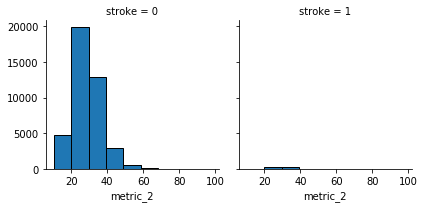

In [7]:
import seaborn as sns

bins = np.linspace(df.metric_2.min(), df.metric_2.max(), 10)
g = sns.FacetGrid(df, col="stroke", palette="Set1", col_wrap=2)
g.map(plt.hist, 'metric_2', bins=bins, ec="k")

plt.show()

### OK metric_2 isn't crazy skewed in distribution, also it may not be a strong predictor for stroke. I'll still impute it though with knn.

### Also there is something weird with age. At least one value of 1000 and at least one below 0. Will take a quick look at that distribution and maybe just exclude those values, particularly if they aren't positive values for stroke.

### First looking at the age distribution, then I'll do a bit of exploratory data analysis.

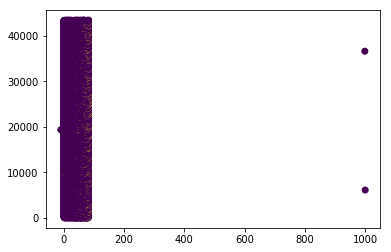

In [8]:
plt.scatter('age', 'id', c= 'stroke', data = df)

plt.show()

### No crazy age distibution, scatterplot shows just a few values at the extremes. I'll just drop them from the dataset since they aren't positive stroke values. If they were, I would have changed the values to 'NA' then knn imputed the age.

### Dropping the extreme outliers for age. Making all observations have values greater than or equal to 0 and less than 150.

In [9]:
df2 = df[(df['age'] >= 0) & (df['age'] < 150)]
df3 = df[(df['age'] < 0) | (df['age'] >= 150)]
df3.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
6123,6124,Female,1000.0,Yes,1,1,B,Rural,74.38,30.0,0,99.61,74.38,formerly smoked,0
19352,19353,Male,-10.0,Yes,0,0,B,Rural,180.48,40.1,0,96.56,180.48,smokes,0
36604,36605,Female,999.0,No,0,0,A,Rural,58.24,17.6,0,97.82,58.24,NaN,0


### Ok, none of these age outliers are positive for stroke so we'll move on without them in the dataframe

In [10]:
df = df2

### Quick correlation map of the numeric factors to stroke to get an exploratory feel for potentially important factors

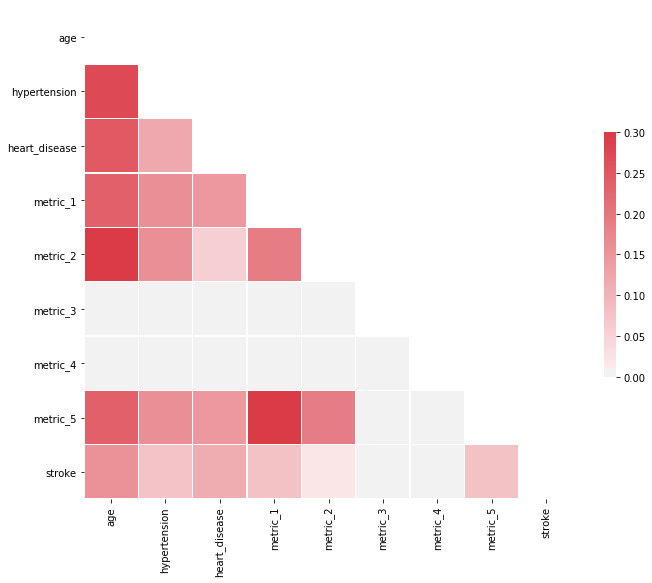

In [11]:
# Compute the correlation matrix
corr = df.drop('id', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### That correlation map is kind of disappointing. Nothing super correlated to stroke. This suggests a PCA dimensionality reduction could be useful.

### Looks like age, hypertension, heart_disease, metric_1, and metric_5 have some weight to predicting stroke.

### We'll do quick tables of percentages for the categorical factors.

In [12]:
df.groupby(['gender'])['stroke'].value_counts(normalize=True)

gender  stroke
Female  0         0.983205
        1         0.016795
Male    0         0.980139
        1         0.019861
Other   0         1.000000
Name: stroke, dtype: float64

In [13]:
df.groupby(['married'])['stroke'].value_counts(normalize=True)

married  stroke
No       0         0.994826
         1         0.005174
Yes      0         0.974835
         1         0.025165
Name: stroke, dtype: float64

In [14]:
df.groupby(['occupation'])['stroke'].value_counts(normalize=True)

occupation  stroke
A           0         0.999675
            1         0.000325
B           0         0.982241
            1         0.017759
C           0         1.000000
D           0         0.963050
            1         0.036950
E           0         0.983640
            1         0.016360
Name: stroke, dtype: float64

In [15]:
df.groupby(['residence'])['stroke'].value_counts(normalize=True)

residence  stroke
Rural      0         0.982256
           1         0.017744
Urban      0         0.981660
           1         0.018340
Name: stroke, dtype: float64

In [16]:
df.groupby(['smoking_status'])['stroke'].value_counts(normalize=True)

smoking_status   stroke
formerly smoked  0         0.970502
                 1         0.029498
never smoked     0         0.982309
                 1         0.017691
smokes           0         0.979729
                 1         0.020271
Name: stroke, dtype: float64

### Quick glance at the percentages suggests that smoking status, occupation, and marriage status may have strong effects on the stroke outcome.


# Data Cleaning and Transformation

## Now it is time to split the data into test / train sets. 

In [17]:
X = df.drop(['stroke'], axis = 1)

y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train['copy_index'] = X_train.index
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (34717, 15) (34717,)
Test set: (8680, 14) (8680,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Data imputation

### First I'm going to split the dataframes into numeric and categorical factors. 
### Numeric I will impute medians, categorical I will use knn.

In [18]:
X_num = X_train.drop(['gender', 'married', 'occupation', 'residence', 'smoking_status'], 
                 axis = 1)

In [19]:
X_cat = X_train.drop(['age', 'hypertension', 'heart_disease', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'metric_5'], 
                 axis = 1)

### First, I'll impute the median for metric_2 to fill NA. This is a general imputer that can work on future numeric data as well by imputing the median.

In [20]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X_num = pd.DataFrame(imputer.fit_transform(X_num), columns = X_num.columns)

In [21]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34717 entries, 0 to 34716
Data columns (total 10 columns):
id               34717 non-null float64
age              34717 non-null float64
hypertension     34717 non-null float64
heart_disease    34717 non-null float64
metric_1         34717 non-null float64
metric_2         34717 non-null float64
metric_3         34717 non-null float64
metric_4         34717 non-null float64
metric_5         34717 non-null float64
copy_index       34717 non-null float64
dtypes: float64(10)
memory usage: 2.6 MB


In [22]:
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34717 entries, 6234 to 17531
Data columns (total 7 columns):
id                34717 non-null int64
gender            34717 non-null object
married           34717 non-null object
occupation        34717 non-null object
residence         34717 non-null object
smoking_status    24092 non-null object
copy_index        34717 non-null int64
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


### Now I will create the imputers / transformers for the categorical data.

### First is the knn of the smoking_status using the numeric vars. 

### Start off by making a dataframe adequate for training the knn classifier.

In [23]:
X_knn_train_df = X_num.merge(X_cat[['smoking_status','id']].dropna(), on = 'id')

### Make the dataframe that contains the smoking_statuses to be predicted.

In [24]:
X_knn_na = X_num.merge(X_cat[['id','smoking_status']][X_cat[['smoking_status']].isnull().any(axis=1)], on = 'id').set_index('copy_index') 

### Test for the best value of k in knn based on F1 score.

In [36]:
Ks = 15
mean_f1 = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_knn_train_df.drop(['smoking_status','id'], axis = 1).set_index('copy_index'), X_knn_train_df['smoking_status'])
    yhat=neigh.predict(X_knn_train_df.drop(['smoking_status', 'id'], axis = 1).set_index('copy_index'))
    mean_f1[n-1] = f1_score(X_knn_train_df['smoking_status'], yhat, average = 'weighted')

mean_f1

array([1.        , 0.67821225, 0.67746343, 0.6291386 , 0.59757074,
       0.58533172, 0.56823205, 0.5560808 , 0.55091008, 0.53521348,
       0.52639469, 0.52583778, 0.51691949, 0.51127349])

### Plot the F1 scores from analyzing a variety of k in knn

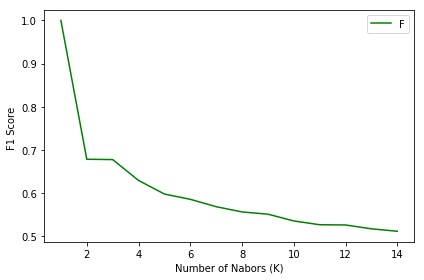

In [37]:
plt.plot(range(1,Ks),mean_f1,'g')
plt.legend(('F1 Score '))
plt.ylabel('F1 Score ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

### Train the knn learner

In [38]:
n = 1
trained_model = KNeighborsClassifier(n_neighbors = 1).fit(X_knn_train_df.drop(['smoking_status', 'id'], axis = 1).set_index('copy_index'), X_knn_train_df['smoking_status'])

### Predict the missing values in smoking status

In [39]:
imputed_values = trained_model.predict(X_knn_na.drop(['smoking_status', 'id'], axis = 1))

X_knn_na['smoking_status'] = imputed_values

X_knn_na.head()

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status
copy_index,,,,,,,,,,
38370.0,38371.0,16.0,0.0,0.0,89.30,35.3,1.0,98.44,89.30,never smoked
17307.0,17308.0,16.0,0.0,0.0,77.47,23.7,0.0,96.15,77.47,smokes
32424.0,32425.0,29.0,0.0,0.0,74.34,26.0,0.0,96.01,74.34,never smoked
24290.0,24291.0,29.0,0.0,0.0,109.22,26.5,0.0,96.54,109.22,formerly smoked
23620.0,23621.0,15.0,0.0,0.0,78.96,19.9,0.0,97.67,78.96,never smoked


### Merge together the original categorical dataframe with the imputed dataframe

In [40]:
X_cat_imputed = X_cat.merge(X_knn_na, on = 'id', how = 'left').set_index('copy_index') 

X_cat_imputed.head()

,id,gender,married,occupation,residence,smoking_status_x,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status_y
copy_index,,,,,,,,,,,,,,,
6234,6235,Female,Yes,B,Rural,never smoked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6947,6948,Female,Yes,B,Rural,never smoked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17708,17709,Female,Yes,B,Urban,smokes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39122,39123,Female,Yes,B,Urban,formerly smoked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38370,38371,Female,No,B,Urban,NaN,16.0,0.0,0.0,89.3,35.3,1.0,98.44,89.3,never smoked


### Drop out the numeric variables out of the imputed categorical dataframe.

In [41]:
X_cat_imputed = X_cat_imputed.drop(['age', 'hypertension', 'heart_disease', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'metric_5'], axis = 1)

X_cat_imputed.head()

,id,gender,married,occupation,residence,smoking_status_x,smoking_status_y
copy_index,,,,,,,
6234,6235,Female,Yes,B,Rural,never smoked,NaN
6947,6948,Female,Yes,B,Rural,never smoked,NaN
17708,17709,Female,Yes,B,Urban,smokes,NaN
39122,39123,Female,Yes,B,Urban,formerly smoked,NaN
38370,38371,Female,No,B,Urban,NaN,never smoked


### Now I unify the two different smoking status factors into one creating all complete cases in the dataframe

In [42]:
X_cat_imputed = X_cat_imputed.fillna('')
X_cat_imputed['smoking_status'] = X_cat_imputed['smoking_status_x'] + X_cat_imputed['smoking_status_y']
X_cat_imputed = X_cat_imputed.drop(['smoking_status_x', 'smoking_status_y'], axis = 1)

In [43]:
X_cat = X_cat_imputed
X_cat.head()

,id,gender,married,occupation,residence,smoking_status
copy_index,,,,,,
6234,6235,Female,Yes,B,Rural,never smoked
6947,6948,Female,Yes,B,Rural,never smoked
17708,17709,Female,Yes,B,Urban,smokes
39122,39123,Female,Yes,B,Urban,formerly smoked
38370,38371,Female,No,B,Urban,never smoked


### Next, I one-hot encode the categorical factors. This is useful for many different learning models that don't handle categorical values well.

In [44]:
X_cat_one_hot = pd.concat([X_cat['id'],pd.get_dummies(X_cat.drop(['id'], axis = 1))], axis=1)

In [45]:
X_cat_one_hot.head()

,id,gender_Female,gender_Male,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,occupation_E,residence_Rural,residence_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
copy_index,,,,,,,,,,,,,,,,
6234,6235,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
6947,6948,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
17708,17709,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1
39122,39123,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0
38370,38371,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0


### And now making the unified dataframe in one-hot context.

In [46]:
X_train_one_hot = X_cat_one_hot.merge(X_num, on = 'id').drop(['copy_index'], axis = 1)
X_train_one_hot.head()

,id,gender_Female,gender_Male,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,...,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5
0,6235,1,0,0,0,1,0,1,0,0,...,1,0,54.0,1.0,0.0,68.08,33.0,0.0,97.78,68.08
1,6948,1,0,0,0,1,0,1,0,0,...,1,0,46.0,0.0,0.0,75.68,27.8,1.0,98.54,75.68
2,17709,1,0,0,0,1,0,1,0,0,...,0,1,35.0,0.0,0.0,61.57,31.8,0.0,99.33,61.57
3,39123,1,0,0,0,1,0,1,0,0,...,0,0,47.0,0.0,0.0,60.65,25.2,1.0,98.88,60.65
4,38371,1,0,0,1,0,0,1,0,0,...,1,0,16.0,0.0,0.0,89.30,35.3,1.0,98.44,89.30


In [47]:
X_train_one_hot = X_train_one_hot.drop(['id'], axis = 1)

### Now I standardize the values for better computational and model performance.

In [48]:
X_train_2 = preprocessing.StandardScaler().fit(X_train_one_hot).transform(X_train_one_hot)

X_train_2[0:10]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.83054372, -0.83009816, -0.01610299, -0.7422295 ,  0.7422295 ,
        -0.40567244,  0.86660032, -0.06543159, -0.43068254, -0.38116165,
         1.00175861, -1.00175861, -0.55142708,  0.85872794, -0.48630495,
         0.52207805,  3.10739825, -0.22323797, -0.84526573,  0.57937237,
        -0.64689089,  0.16931153, -0.84526573],
       [ 0.83054372, -0.83009816, -0.01610299, -0.7422295 ,  0.7422295 ,
        -0.40567244,  0.86660032, -0.06543159, -0.43068254, -0.38116165,
         1.00175861, -1.00175861, -0.55142708,  0.85872794, -0.48630495,
         0.16695071, -0.32181263, -0.22323797, -0.66943646, -0.10285412,
         1.54585575,  0.68726681, -0.66943646],
       [ 0.83054372, -0.83009816, -0.01610299, -0.7422295 ,  0.7422295 ,
        -0.40567244,  0.86660032, -0.06543159, -0.43068254, -0.38116165,
        -0.99824448,  0.99824448, -0.55142708, -1.16451318,  2.0563229 ,
        -0.32134937, -0.32181263, -0.22323797, -0.99587738,  0.42193549,
        -0.64689089,  1.2256

### Final transformation will be dimensionality reduction with PCA. 
### *PCA was pursued after running through the various models below and seeing poor out-of-sample performance. After exploring a few different variants, the first 10 principal components for the standardized one-hot gave the best model performance.*
 - 10 components covers ~ 70% variance

In [49]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_2)

### Also I use the same transformations on the test data set for model comparisons.

In [50]:
X_test['copy_index'] = X_test.index

X_num_test = X_test.drop(['gender', 'married', 'occupation', 'residence', 'smoking_status'], 
                 axis = 1)

X_cat_test = X_test.drop(['age', 'hypertension', 'heart_disease', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'metric_5'], 
                 axis = 1)

X_num_test = pd.DataFrame(imputer.fit_transform(X_num_test), columns = X_num_test.columns)

X_knn_na_test = X_num_test.merge(X_cat_test[['id','smoking_status']][X_cat_test[['smoking_status']].isnull().any(axis=1)], on = 'id').set_index('copy_index') 

imputed_values_test = trained_model.predict(X_knn_na_test.drop(['smoking_status', 'id'], axis = 1))

X_knn_na_test['smoking_status'] = imputed_values_test

X_cat_imputed_test = X_cat_test.merge(X_knn_na_test, on = 'id', how = 'left').set_index('copy_index') 

X_cat_imputed_test = X_cat_imputed_test.drop(['age', 'hypertension', 'heart_disease', 'metric_1', 'metric_2', 'metric_3', 'metric_4', 'metric_5'], axis = 1)

X_cat_imputed_test = X_cat_imputed_test.fillna('')

X_cat_imputed_test['smoking_status'] = X_cat_imputed_test['smoking_status_x'] + X_cat_imputed_test['smoking_status_y']

X_cat_imputed_test = X_cat_imputed_test.drop(['smoking_status_x', 'smoking_status_y'], axis = 1)

X_cat_test = X_cat_imputed_test

X_cat_one_hot_test = pd.concat([X_cat_test['id'],pd.get_dummies(X_cat_test.drop(['id'], axis = 1))], axis=1)

X_test_one_hot = X_cat_one_hot_test.merge(X_num_test, on = 'id').drop(['copy_index'], axis = 1)

X_test_one_hot = X_test_one_hot.drop(['id'], axis = 1)

X_test_2 = preprocessing.StandardScaler().fit(X_test_one_hot).transform(X_test_one_hot)

X_test_pca = pca.transform(X_test_2)

X_test_one_hot.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:35: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


,gender_Female,gender_Male,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,occupation_E,...,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5
0,0,1,0,1,0,1,0,0,0,0,...,1,0,9.0,0.0,0.0,85.75,17.6,0.0,98.07,85.75
1,1,0,0,1,0,0,1,0,0,0,...,0,1,28.0,0.0,0.0,98.95,28.5,0.0,97.98,98.95
2,0,1,0,0,1,0,1,0,0,0,...,0,1,39.0,0.0,0.0,87.12,31.6,0.0,97.27,87.12
3,1,0,0,1,0,1,0,0,0,0,...,1,0,5.0,0.0,0.0,86.54,15.1,0.0,97.94,86.54
4,0,1,0,0,1,0,1,0,0,0,...,0,1,32.0,0.0,0.0,157.35,29.7,0.0,98.71,157.35


# Data Modeling
## Will try a variety of quick models, then go into more complex attempts to characterize the generalizability of the different classification methods to this problem.

## Logistic Regression Classification

In [59]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_pca, y_train)
yhat_LR = LR.predict(X_train_pca)
print (classification_report(y_train, yhat_LR))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34091
           1       0.00      0.00      0.00       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.49      0.50      0.50     34717
weighted avg       0.96      0.98      0.97     34717



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
yhat_LR = LR.predict(X_test_pca)
print (classification_report(y_test, yhat_LR))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Regularized Logistic Regression Classification

In [61]:
LR_reg = LogisticRegression(solver = 'lbfgs', penalty = 'l2', C=0.5).fit(X_train_pca, y_train)
yhat_LR_reg = LR_reg.predict(X_train_pca)
print(classification_report(y_train, yhat_LR_reg))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34091
           1       0.00      0.00      0.00       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.49      0.50      0.50     34717
weighted avg       0.96      0.98      0.97     34717



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
yhat_LR_reg = LR_reg.predict(X_test_pca)
print(classification_report(y_test, yhat_LR_reg))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## k-Nearest Neighbors Classification

### Testing for optimal k values in knn

In [63]:
Ks = 15
mean_f1 = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_pca,y_train)
    yhat=neigh.predict(X_train_pca)
    mean_f1[n-1] = f1_score(y_train, yhat)

mean_f1

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages

array([1.        , 0.10015175, 0.18559557, 0.01265823, 0.02194357,
       0.00318979, 0.00636943, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### Quick plot of F1 scores

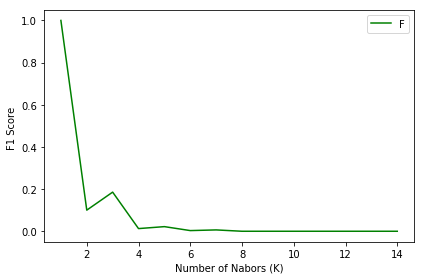

In [64]:
plt.plot(range(1,Ks),mean_f1,'g')
plt.legend(('F1 Score '))
plt.ylabel('F1 Score ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

### Training the knn model

In [66]:
k = 1

neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_pca,y_train)
yhat_knn = neigh.predict(X_train_pca)
print (classification_report(y_train, yhat_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34091
           1       1.00      1.00      1.00       626

   micro avg       1.00      1.00      1.00     34717
   macro avg       1.00      1.00      1.00     34717
weighted avg       1.00      1.00      1.00     34717



In [67]:
yhat_knn = neigh.predict(X_test_pca)
print (classification_report(y_test, yhat_knn))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8523
           1       0.08      0.08      0.08       157

   micro avg       0.97      0.97      0.97      8680
   macro avg       0.53      0.53      0.53      8680
weighted avg       0.97      0.97      0.97      8680



## Decision Tree Classification

## Testing to optimize the max depth in the decision tree.

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


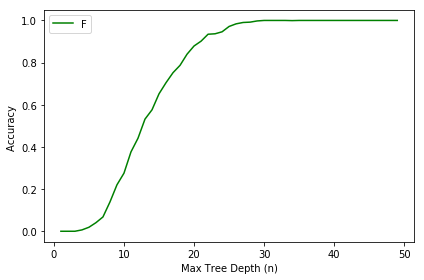

In [69]:
Ks = 50
mean_f1 = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    decTree = DecisionTreeClassifier(criterion = "entropy", max_depth = n).fit(X_train_pca,y_train)
    yhat=decTree.predict(X_train_pca)
    mean_f1[n-1] = f1_score(y_train, yhat)

mean_f1

plt.plot(range(1,Ks),mean_f1,'g')
plt.legend(('F1-score '))
plt.ylabel('Accuracy ')
plt.xlabel('Max Tree Depth (n)')
plt.tight_layout()
plt.show()

In [70]:
mean_f1

array([0.        , 0.        , 0.        , 0.00636943, 0.01898734,
       0.04068858, 0.06779661, 0.13884786, 0.22033898, 0.27548209,
       0.37644046, 0.44114002, 0.53193961, 0.57596372, 0.65189873,
       0.70468432, 0.75222113, 0.78701051, 0.83989021, 0.87886826,
       0.90165361, 0.93457944, 0.93670886, 0.94612795, 0.97142857,
       0.98384491, 0.99032258, 0.99194847, 0.99760192, 1.        ,
       1.        , 1.        , 1.        , 0.99920064, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

### Chose the max depth based on where the 'knee' was in the curve.

In [71]:
decTree = DecisionTreeClassifier(criterion="entropy", max_depth = 20)

decTree.fit(X_train_pca,y_train)
predTree = decTree.predict(X_train_pca)
print (classification_report(y_train, predTree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34091
           1       0.98      0.80      0.88       626

   micro avg       1.00      1.00      1.00     34717
   macro avg       0.99      0.90      0.94     34717
weighted avg       1.00      1.00      1.00     34717



In [72]:
predTree = decTree.predict(X_test_pca)
print (classification_report(y_test, predTree))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8523
           1       0.05      0.04      0.05       157

   micro avg       0.97      0.97      0.97      8680
   macro avg       0.51      0.51      0.51      8680
weighted avg       0.97      0.97      0.97      8680



## Support Vector Machine Classification

In [73]:
clf = svm.SVC(kernel='rbf', C = 1)
clf.fit(X_train_pca, y_train)
yhat_SVM = clf.predict(X_train_pca)
print (classification_report(y_train, yhat_SVM))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34091
           1       0.00      0.00      0.00       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.49      0.50      0.50     34717
weighted avg       0.96      0.98      0.97     34717



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
yhat_SVM = clf.predict(X_test_pca)
print (classification_report(y_test, yhat_SVM))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## OK, none of the first pass models performed as well as hoped on out-of-sample F1 scores. Now trying more advanced classification models.

## One Class SVM Outlier Detection (Classification)

In [76]:
clf = OneClassSVM(gamma='auto').fit(X_train_pca)
yhat = clf.predict(X_train_pca)
yhat = np.where(yhat==1, 0, yhat) 
yhat = np.where(yhat==-1, 1, yhat) 
print (classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.99      0.50      0.67     34091
           1       0.03      0.70      0.05       626

   micro avg       0.51      0.51      0.51     34717
   macro avg       0.51      0.60      0.36     34717
weighted avg       0.97      0.51      0.66     34717



In [77]:
yhat = clf.predict(X_test_pca)
yhat = np.where(yhat==1, 0, yhat) 
yhat = np.where(yhat==-1, 1, yhat) 
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.99      0.51      0.68      8523
           1       0.03      0.75      0.05       157

   micro avg       0.52      0.52      0.52      8680
   macro avg       0.51      0.63      0.37      8680
weighted avg       0.97      0.52      0.67      8680



## Hyperparameter-tuned Random Forest Classification

In [78]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,
                  109,
                  118,
                  127,
                  136,
                  145,
                  154,
                  163,
                  172,
                  181,
                  190,
                  200,
                  209,
                  218,
                  227,
                  236,
                  245,
                  254,
                  263,
                  272,
                  281,
                  290,
                  300,
                  309,
                  318,
                  327,
                  336,
                  345,
                  354,
                  363,
                  372,
                  381,
                  390,
                  400,
                  40

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [79]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, scoring = 'f1')# Fit the random search model

rf_random.fit(X_train_pca, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total= 1.6min
[CV] n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total= 1.6min
[CV] n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=963, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total= 1.6min
[CV] n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  45.5s
[CV] n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  45.0s
[CV] n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=645, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  45.1s
[CV] n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, total= 1.6min
[CV] n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, total= 1.6min
[CV] n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=627, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, total= 1.6min
[CV] n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total= 1.3min
[CV] n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total= 1.3min
[CV] n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=863, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total= 1.3min
[CV] n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total= 1.0min
[CV] n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total= 1.0min
[CV] n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=690, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total= 1.0min
[CV] n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=  49.8s
[CV] n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=  49.5s
[CV] n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=554, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=  49.4s
[CV] n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total= 2.5min
[CV] n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total= 2.5min
[CV] n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=954, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total= 2.5min
[CV] n_estimators=663, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=663

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=309, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  28.2s
[CV] n_estimators=309, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=309, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  27.8s
[CV] n_estimators=309, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=309, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  27.6s
[CV] n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total= 2.3min
[CV] n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total= 2.3min
[CV] n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=918, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total= 2.3min
[CV] n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.0min
[CV] n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.0min
[CV] n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=872, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.1min
[CV] n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  55.0s
[CV] n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  55.1s
[CV] n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  51.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=  36.3s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=  35.6s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=  36.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=  18.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=  17.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=  17.6s
[CV] n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=  42.6s
[CV] n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=  42.7s
[CV] n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=272, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=  42.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 
[CV]  n_estimators=90

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=718, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.1min
[CV] n_estimators=718, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=718, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.1min
[CV] n_estimators=718, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=718, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.1min
[CV] n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True, total= 1.1min
[CV] n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True, total= 1.1min
[CV] n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=727, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=True, total= 1.1min
[CV] n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, total= 2.3min
[CV] n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, total= 2.3min
[CV] n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=945, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, total= 2.3min
[CV] n_estimators=972, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=972, min_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=381, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  35.0s
[CV] n_estimators=381, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=381, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  35.6s
[CV] n_estimators=381, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=381, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True, total=  35.5s
[CV] n_estimators=527, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=527, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  49.2s
[CV] n_estimators=527, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=527, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  49.7s
[CV] n_estimators=527, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=527, min_sampl

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=909, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total= 1.1min
[CV] n_estimators=909, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=909, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total= 1.1min
[CV] n_estimators=909, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=909, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total= 1.1min
[CV] n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  24.8s
[CV] n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  24.9s
[CV] n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  n_estimators=263, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  24.7s
[CV] n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total= 1.8min
[CV] n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total= 1.8min
[CV] n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=763, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total= 1.9min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, mi

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 116.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'n_estimators': [100, 109, 118, 127, 136, 145, 154, 163, 172, 181, 190, 200, 209, 218, 227, 236, 245, 254, 263, 272, 281, 290, 300, 309, 318, 327, 336, 345, 354, 363, 372, 381, 390, 400, 409, 418, 427, 436, 445, 454, 463, 472, 481, 490, 500, 509, 518, 527, 536, 545, 554, 563, 57..., None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_d

In [80]:
rf_random.best_params_

{'n_estimators': 272,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

In [91]:
best_random = rf_random.best_estimator_
print (classification_report(y_train, best_random.predict(X_train_pca)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34091
           1       1.00      1.00      1.00       626

   micro avg       1.00      1.00      1.00     34717
   macro avg       1.00      1.00      1.00     34717
weighted avg       1.00      1.00      1.00     34717



In [92]:
print (classification_report(y_test, best_random.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.12      0.01      0.01       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.55      0.50      0.50      8680
weighted avg       0.97      0.98      0.97      8680



## AdaBoost Classification

In [82]:
clf = AdaBoostClassifier()
clf.fit(X_train_pca, y_train)
yhat = clf.predict(X_train_pca)
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34091
           1       1.00      0.00      0.00       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.99      0.50      0.50     34717
weighted avg       0.98      0.98      0.97     34717



In [83]:
yhat = clf.predict(X_test_pca)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes Classification

In [84]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
yhat = clf.predict(X_train_pca)
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     34091
           1       0.07      0.03      0.04       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.53      0.51      0.51     34717
weighted avg       0.97      0.98      0.97     34717



In [85]:
yhat = clf.predict(X_test_pca)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8523
           1       0.06      0.03      0.03       157

   micro avg       0.97      0.97      0.97      8680
   macro avg       0.52      0.51      0.51      8680
weighted avg       0.97      0.97      0.97      8680



## Quadratic Discriminant Analysis Classification

In [86]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_pca, y_train)
yhat = clf.predict(X_train_pca)
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     34091
           1       0.07      0.18      0.10       626

   micro avg       0.95      0.95      0.95     34717
   macro avg       0.53      0.57      0.54     34717
weighted avg       0.97      0.95      0.96     34717



In [87]:
yhat = clf.predict(X_test_pca)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8523
           1       0.07      0.15      0.09       157

   micro avg       0.95      0.95      0.95      8680
   macro avg       0.53      0.56      0.53      8680
weighted avg       0.97      0.95      0.96      8680



## Multilayer Perceptron Classification

In [88]:
clf = MLPClassifier(alpha=1, max_iter=1000)
clf.fit(X_train_pca, y_train)
yhat = clf.predict(X_train_pca)
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34091
           1       0.00      0.00      0.00       626

   micro avg       0.98      0.98      0.98     34717
   macro avg       0.49      0.50      0.50     34717
weighted avg       0.96      0.98      0.97     34717



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
yhat = clf.predict(X_test_pca)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

   micro avg       0.98      0.98      0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Results

## Quick review of the performance of various classification models on both stroke and non-stroke (1 or 0) and in-sample vs. out-of-sample F1 scores

| Model      | In-sample vs. Out-of-sample | Classification | Precision | Recall | F1 Score |
| ----------- | ----------- | ----------- | ----------- |  ----------- | ----------- |
| Logistic Regression      | In-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Logistic Regression      | In-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Logistic Regression      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Logistic Regression      | Out-of-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Regularized Logistic Regression      | In-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Regularized Logistic Regression      | In-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Regularized Logistic Regression      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Regularized Logistic Regression      | Out-of-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| k-Nearest Neighbors      | In-sample       | No stroke | 1.0 | 1.0 | 1.0 |
| k-Nearest Neighbors      | In-sample       | Stroke | 1.0 | 1.0 | 1.0 |
| k-Nearest Neighbors      | Out-of-sample       | No stroke | 0.98 | 0.98 | 0.98 |
| k-Nearest Neighbors      | Out-of-sample       | Stroke | 0.08 | 0.08 | 0.08 |
| Decision Tree      | In-sample       | No stroke | 1.0 | 1.0 | 1.0 |
| Decision Tree      | In-sample       | Stroke | 0.98 | 0.80 | 0.88 |
| Decision Tree      | Out-of-sample       | No stroke | 0.98 | 0.98 | 0.98 |
| Decision Tree      | Out-of-sample       | Stroke | 0.05 | 0.04 | 0.05 |
| Support Vector Machine (2 class)      | In-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Support Vector Machine (2 class)      | In-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Support Vector Machine (2 class)      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Support Vector Machine (2 class)      | Out-of-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Support Vector Machine (1 class outlier)      | In-sample       | No stroke | 0.99 | 0.50 | 0.67 |
| Support Vector Machine (1 class outlier)      | In-sample       | Stroke | 0.03 | 0.70 | 0.05 |
| Support Vector Machine (1 class outlier)      | Out-of-sample       | No stroke | 0.99 | 0.51 | 0.68 |
| Support Vector Machine (1 class outlier)      | Out-of-sample       | Stroke | 0.03 | 0.75 | 0.05 |
| Hyperparameter-tuned Random Forest      | In-sample       | No stroke | 1.0 | 1.0 | 1.0 |
| Hyperparameter-tuned Random Forest      | In-sample       | Stroke | 1.0 | 1.0 | 1.0 |
| Hyperparameter-tuned Random Forest      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Hyperparameter-tuned Random Forest      | Out-of-sample       | Stroke | 0.12 | 0.01 | 0.01 |
| AdaBoost      | In-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| AdaBoost      | In-sample       | Stroke | 1.0 | 0.0 | 0.0 |
| AdaBoost      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| AdaBoost      | Out-of-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Naive Bayes      | In-sample       | No stroke | 0.98 | 0.99 | 0.99 |
| Naive Bayes      | In-sample       | Stroke | 0.07 | 0.03 | 0.04 |
| Naive Bayes      | Out-of-sample       | No stroke | 0.98 | 0.99 | 0.99 |
| Naive Bayes      | Out-of-sample       | Stroke | 0.06 | 0.03 | 0.03 |
| Quadratic Discriminant Analysis      | In-sample       | No stroke | 0.98 | 0.96 | 0.97 |
| Quadratic Discriminant Analysis      | In-sample       | Stroke | 0.07 | 0.18 | 0.10 |
| Quadratic Discriminant Analysis      | Out-of-sample       | No stroke | 0.98 | 0.96 | 0.97 |
| Quadratic Discriminant Analysis      | Out-of-sample       | Stroke | 0.07 | 0.15 | 0.09 |
| Multilayer Perceptron      | In-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Multilayer Perceptron      | In-sample       | Stroke | 0.0 | 0.0 | 0.0 |
| Multilayer Perceptron      | Out-of-sample       | No stroke | 0.98 | 1.0 | 0.99 |
| Multilayer Perceptron      | Out-of-sample       | Stroke | 0.0 | 0.0 | 0.0 |

## Based on the figures of merit from the modeling exercise I have the following conclusions:
1. A stroke could be predicted well (in-sample error only) for both precision and recall using k-Nearest Neighbors, a Decision Tree, or a Random Forest, with the Random Forest being best,
2. The most generalizable models were k-Nearest Neighbors, Naive Bayes, Quadratic Discriminant Analysis, and the one-class SVM,
3. The performance on out-of-sample data for all models is too poor for generalization and deployment of any given model.


## If the ACO wants the McAnally Consulting Group to continue pursuing a predictive data model for strokes, I have the following recommendations:
1. Collect and provide more data either from current patients or look at engineering a larger dataset from legacy records,
2. Provide funding for more computational resources to fit larger computational complex models for strokes using deep neural networks,
3. If possible, provide time series datasets of patients to look for dynamic behaviour in the response variable to be predicted.